**Modules**

In [34]:
# # Installs 
# !pip install pandas_datareader

# Imports
import pandas as pd
from pandas_datareader import data as web
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

START_DATE = "2005-12-31"
END_DATE = "2021-12-31"
EPOCH_START = pd.Timestamp("1970-01-01") # Do not change

plt.rcParams.update({
    "font.size": 13,          # base font size
    "axes.labelsize": 13,     # x- and y-labels
    "axes.titlesize": 13,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "legend.fontsize": 13,
})

In [35]:
# Path to final dataset
data_path = '/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Characteristics Prepared/With Insider/with_insider.parquet'

# Load the dataset
df = pd.read_parquet(data_path)

# # Display the first few rows of the dataframe
# df.head()

In [36]:
### mvel1 Size-only (NYSE-based) ###

### Load CRSP MONTHLY data ###
path = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/SQLite/Tables"

if os.path.exists(path):
    crsp_monthly = pd.read_parquet(os.path.join(path, "crsp_monthly.parquet"))
else:
    raise FileNotFoundError("No path found")


# Rename and align to month end
crsp_monthly = crsp_monthly.rename(columns={"date": "month"})
crsp_monthly["month"] = EPOCH_START + pd.to_timedelta(crsp_monthly["month"], unit="D")
crsp_monthly["month"] = crsp_monthly["month"] + pd.offsets.MonthEnd(0)

# Restrict sample period
crsp_monthly = crsp_monthly[
    (crsp_monthly["month"] >= pd.to_datetime(START_DATE)) &
    (crsp_monthly["month"] <= pd.to_datetime(END_DATE))
]

# Ensure correct permno format
crsp_monthly["permno"] = (
    crsp_monthly["permno"]
    .astype(str)
    .str.lstrip("0")
)
crsp_monthly["permno"] = pd.to_numeric(
    crsp_monthly["permno"], errors="coerce"
).astype("Int32")

### Assign exchange ###
def assign_exchange(primaryexch):
    if primaryexch == "N":
        return "NYSE"
    elif primaryexch == "A":
        return "AMEX"
    elif primaryexch == "Q":
        return "NASDAQ"
    else:
        return "Other"

crsp_monthly["exchange"] = crsp_monthly["primaryexch"].apply(assign_exchange)

### NYSE sample for breakpoints ###
crsp_nyse = crsp_monthly[crsp_monthly["exchange"] == "NYSE"].copy()

crsp_nyse

### NYSE-based size breakpoints ###
def nyse_size_breakpoints(df):
    out = []
    for month, group in df.groupby("month"):
        out.append({
            "month": month,
            "size_p33": group["mktcap"].quantile(0.33),
            "size_p67": group["mktcap"].quantile(0.67),
        })
    return (
        pd.DataFrame(out)
        .sort_values("month")
        .reset_index(drop=True)
    )
    
breakpoints = nyse_size_breakpoints(crsp_nyse)

# Lag breakpoints (t-1 applies at t)
breakpoints_lag = breakpoints.copy()
breakpoints_lag["month"] = breakpoints_lag["month"] + pd.offsets.MonthEnd(1)

### Full stock universe ###
data_path = (
    "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Characteristics Prepared/With Insider for Variable Selection/with_insider.parquet"
)

full_universe = pd.read_parquet(data_path)

# Column lists
path_info_cols = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Characteristics Prepared/With Insider for Variable Selection/info_cols.txt"
path_gkx_cols = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Characteristics Prepared/With Insider for Variable Selection/gkx_cols.txt"
path_insider_cols = "/Users/jonas/Library/CloudStorage/OneDrive-UniversityofCopenhagen/Kandidat/Thesis/2.0 Data/Characteristics Prepared/With Insider for Variable Selection/insider_cols.txt"

info_cols = pd.read_csv(path_info_cols, header=None, sep="\s+")[0].tolist()
gkx_cols = pd.read_csv(path_gkx_cols, header=None, sep="\s+")[0].tolist()
insider_cols = pd.read_csv(path_insider_cols, header=None, sep="\s+")[0].tolist()

# Keep info + insider columns
full_universe = full_universe[info_cols + insider_cols]

# Drop macro variables
macro_cols = [c for c in full_universe.columns if c.startswith("macro_")]
full_universe = full_universe.drop(columns=macro_cols)

# Align month
full_universe["month"] = pd.to_datetime(full_universe["month"]) + pd.offsets.MonthEnd(0)

# Restrict sample period
full_universe = full_universe[
    (full_universe["month"] >= pd.to_datetime(START_DATE)) &
    (full_universe["month"] <= pd.to_datetime(END_DATE))
]

### Restrict the stock universe (size only) ###
full_universe = full_universe.merge(
    breakpoints_lag,
    on="month",
    how="inner"
)

# size tercile (NYSE-based, lagged)
big = full_universe[
    full_universe["mktcap_lag"] >= full_universe["size_p67"]
]

mid = full_universe[
    (full_universe["mktcap_lag"] > full_universe["size_p33"]) &
    (full_universe["mktcap_lag"] <= full_universe["size_p67"])
]

small = full_universe[
    full_universe["mktcap_lag"] <= full_universe["size_p33"]
]

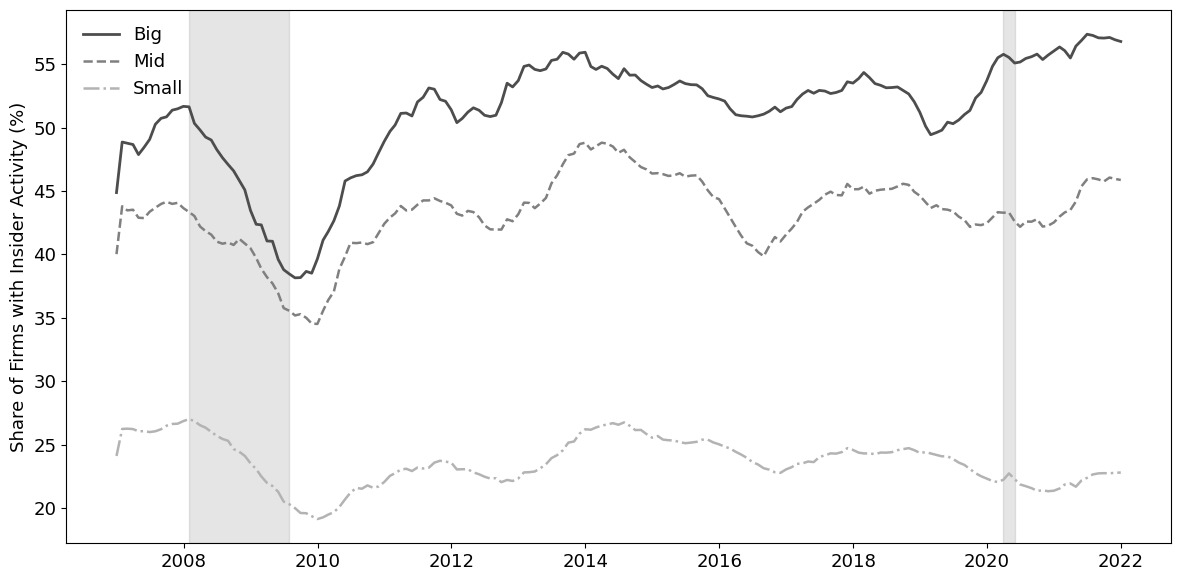

In [37]:
# Insider signal columns
insider_cols = [
    'is_txn_purchase_x_is_tit_ceo',
    'is_txn_purchase_x_is_tit_cfo',
    'is_txn_purchase_x_is_tit_coo',
    'is_txn_purchase_x_is_tit_director',
    'is_txn_purchase_x_is_tit_other_officer',
    'is_txn_purchase_x_is_tit_ten_percent_owner',
    'is_txn_purchase_x_is_tit_vice_president',
    'is_txn_sell_x_is_tit_ceo',
    'is_txn_sell_x_is_tit_cfo',
    'is_txn_sell_x_is_tit_coo',
    'is_txn_sell_x_is_tit_director',
    'is_txn_sell_x_is_tit_other_officer',
    'is_txn_sell_x_is_tit_ten_percent_owner',
    'is_txn_sell_x_is_tit_vice_president',
]

def compute_monthly_ratio(df, label):
    df = df.copy()

    # Binary firm-month insider signal
    df["insider_signal"] = (
        df[insider_cols]
        .fillna(0)
        .eq(1)
        .any(axis=1)
        .astype(int)
    )

    monthly = (
        df.groupby("month")
        .agg(
            active_permnos=(
                "permno",
                lambda x: x[df.loc[x.index, "insider_signal"] == 1].nunique()
            ),
            total_permnos=("permno", "nunique"),
        )
        .reset_index()
    )

    monthly["ratio"] = monthly["active_permnos"] / monthly["total_permnos"]
    monthly["size_grp"] = label

    return monthly[["month", "ratio", "size_grp"]]

# Compute monthly ratios by size group
small_ts = compute_monthly_ratio(small, "Small")
mid_ts   = compute_monthly_ratio(mid, "Mid")
big_ts   = compute_monthly_ratio(big, "Big")

# Combine
plot_df = (
    pd.concat([small_ts, mid_ts, big_ts], ignore_index=True)
    .sort_values("month")
)

# 12-month MA with full window only
plot_df["ratio_ma12"] = (
    plot_df
    .groupby("size_grp")["ratio"]
    .transform(lambda x: x.rolling(window=12, min_periods=12).mean())
)

plot_df = plot_df.dropna(subset=["ratio_ma12"])

# Load NBER recession data
recession = web.DataReader(
    "USREC",
    "fred",
    plot_df["month"].min(),
    plot_df["month"].max()
)

recession.index = pd.to_datetime(recession.index)
recession = recession.resample("ME").max()

# Identify recession periods
rec_periods = []
in_rec = False

for date, value in recession["USREC"].items():
    if value == 1 and not in_rec:
        in_rec = True
        start = date
    elif value == 0 and in_rec:
        in_rec = False
        end = date
        rec_periods.append((start, end))

if in_rec:
    rec_periods.append((start, recession.index.max()))

plt.figure(figsize=(12, 6))

for start, end in rec_periods:
    plt.axvspan(start, end, color="grey", alpha=0.2)

style_map = {
    "Small": {"color": "0.7", "linestyle": "dashdot", "linewidth": 1.8},
    "Mid":   {"color": "0.5", "linestyle": "--",      "linewidth": 1.8},
    "Big":   {"color": "0.3", "linestyle": "-",       "linewidth": 2.0},
}

for grp, g in plot_df.groupby("size_grp"):
    plt.plot(
        g["month"],
        g["ratio_ma12"] * 100,
        label=grp,
        **style_map[grp]
    )

plt.ylabel("Share of Firms with Insider Activity (%)")
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()

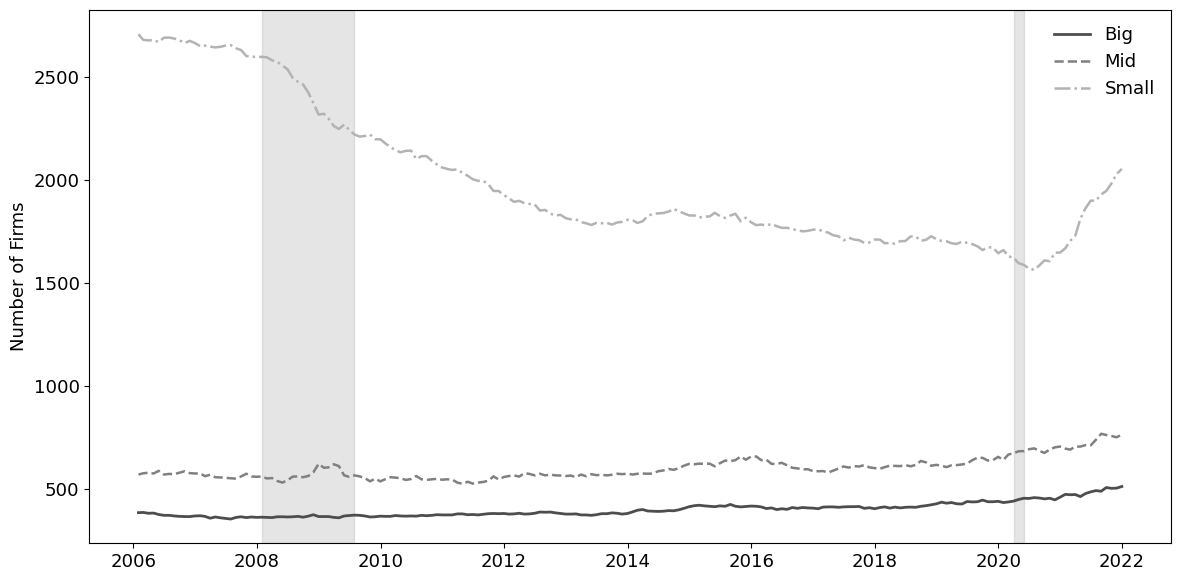

In [38]:
# Compute monthly number of unique permnos per size group
def compute_monthly_counts(df, label):
    monthly = (
        df.groupby("month")
          .agg(n_permnos=("permno", "nunique"))
          .reset_index()
    )
    monthly["size_grp"] = label
    return monthly[["month", "n_permnos", "size_grp"]]

small_cnt = compute_monthly_counts(small, "Small")
mid_cnt   = compute_monthly_counts(mid, "Mid")
big_cnt   = compute_monthly_counts(big, "Big")

count_df = (
    pd.concat([small_cnt, mid_cnt, big_cnt], ignore_index=True)
    .sort_values("month")
)

# Load NBER recession data
recession = web.DataReader(
    "USREC",
    "fred",
    count_df["month"].min(),
    count_df["month"].max()
)

recession.index = pd.to_datetime(recession.index)
recession = recession.resample("ME").max()

# Identify recession periods
rec_periods = []
in_rec = False

for date, value in recession["USREC"].items():
    if value == 1 and not in_rec:
        in_rec = True
        start = date
    elif value == 0 and in_rec:
        in_rec = False
        end = date
        rec_periods.append((start, end))

if in_rec:
    rec_periods.append((start, recession.index.max()))

# Plot number of firms by size group
plt.figure(figsize=(12, 6))

for start, end in rec_periods:
    plt.axvspan(start, end, color="grey", alpha=0.2)

style_map = {
    "Small": {"color": "0.7", "linestyle": "dashdot", "linewidth": 1.8},
    "Mid":   {"color": "0.5", "linestyle": "--",      "linewidth": 1.8},
    "Big":   {"color": "0.3", "linestyle": "-",       "linewidth": 2.0},
}

for grp, g in count_df.groupby("size_grp"):
    plt.plot(
        g["month"],
        g["n_permnos"],
        label=grp,
        **style_map[grp]
    )

plt.ylabel("Number of Firms")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()